In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import numpy as np
import pandas as pd
import xarray as xr
import itertools as it
import datetime
import scipy.stats as stats
from scipy.io import loadmat
from scipy.interpolate import CubicSpline, interp1d
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle
def convert_datetime(dt):
  return pd.to_datetime(dt - 719529, unit='D').round('min')

In [ ]:
data = np.load('/content/drive/MyDrive/sfbay_sediment.npy', allow_pickle=True).item()
n_points = len(data['tstart'])

In [ ]:
full_df = pd.DataFrame(index=list(range(n_points)), columns=list(data.keys()), dtype=object)
for key, dat in data.items():
  if dat.shape == (n_points,):
    full_df[key] = dat
  else:
    for i in range(n_points):
      full_df.at[i, key] = dat[i,:]

Data Droppin'

---



loading the stuff

In [ ]:
data = np.load('/content/drive/MyDrive/sfbay_sediment.npy', allow_pickle=True).item()
n_points = len(data['npreal'])
full_df = pd.DataFrame(index=list(range(n_points)), columns=list(data.keys()), dtype=object)
for key, dat in data.items():
  if dat.shape == (n_points,):
    full_df[key] = dat
  else:
    for i in range(n_points):
      full_df.at[i, key] = dat[i,:]
print(data.keys())

dict_keys(['tstart', 'omega', 'ub', 'cw5', 'upwp5', 'uw_wave5', 'upwp15', 'uw_wave15', 'upwp45', 'uw_wave45', 'sal', 'temp', 'depth', 'apg9', 'cpg9', 'npreal', 'gamma', 'c650', 'bb15', 'bb45', 'c15', 'c45', 'rhoinvs15', 'rhoinvs45', 'dmean15', 'dmean45', 'chl15', 'chl45', 'chlatten15', 'chlatten45', 'aratio450_676', 'aratio676_650', 'aratio412_650', 'ssc5', 'ssc15', 'ssc45', 'ubar5', 'ubar15', 'ubar45', 'vbar5', 'vbar15', 'vbar45'])


In [ ]:
cols_to_extract = [key for key, dat in data.items() if dat.shape == (n_points,)]
cols_to_drop = ['cw5', 'depth', 'apg9', 'cpg9', 'npreal', 'chl45', 'ssc5', 'ubar15', 'ubar45', 'vbar15', 'vbar45']
# cols_to_drop = []
cols_to_extract = [k for k in cols_to_extract if k not in cols_to_drop]
df = full_df[cols_to_extract].copy()
df['tstart'] = convert_datetime(df['tstart'])
df.sort_values('tstart', inplace=True)

n_shifts = 12
tau = 1
for i in range(n_shifts):
  df[f'ubar5_delayed_{i+1}'] = df['ubar5'].shift(tau*(i+1))
df.dropna(inplace=True)

In [ ]:
# Define the feature matrix X and the target vector y
feature_labels = [k for k in cols_to_extract if ('dmean' not in k) and ('tstart' not in k)]
target_labels = [k for k in cols_to_extract if 'dmean' in k]
X = df[feature_labels]
y = df[target_labels]

In [ ]:
# Define all hyper-parameters
test_size = 0.3
seed = 42
layer_sizes = [144, 12, 4]
l1, l2 = 0.01, 0.01
activation = 'relu'
n_epochs = 1000
batch_size = 20
val_split = 0.2

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# Standardize the features
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
Y_scaler = StandardScaler()
y_train = Y_scaler.fit_transform(y_train)
y_test = Y_scaler.transform(y_test)

#Sequential neural net model:

In [ ]:
# Initialize a sequential model
model = Sequential()
regularizer = L1L2(l1, l2)

for i, layer_sz in enumerate(layer_sizes):
  if i == 0:
    model.add(Dense(units=layer_sz, input_dim=X.shape[1], kernel_regularizer=regularizer, activation=activation))
  else:
    model.add(Dense(units=layer_sz, input_dim=layer_sizes[i-1], kernel_regularizer=regularizer, activation=activation))
# readout layer
model.add(Dense(units=y.shape[1], input_dim=(layer_sizes[-1] if len(layer_sizes) else X.shape[1]), activation='linear'))

# Compile the model with mean squared error loss and an optimizer
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_81 (Dense)                     │ (None, 144)                 │           4,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 12)                  │           1,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 2)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,978 (23.35 KB)

 Trainable params: 5,978 (23.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=val_split, verbose=1)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 7.4762 - val_loss: 6.4723
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6569 - val_loss: 5.9128
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0685 - val_loss: 5.3779
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4949 - val_loss: 4.8725
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9570 - val_loss: 4.3923
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4557 - val_loss: 3.9485
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9923 - val_loss: 3.5384
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5683 - val_loss: 3.1668
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1829 - val_loss: 2.8292
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8363 - val_loss: 2.5271
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5280 - val_loss: 2.2604
Epoch 12/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

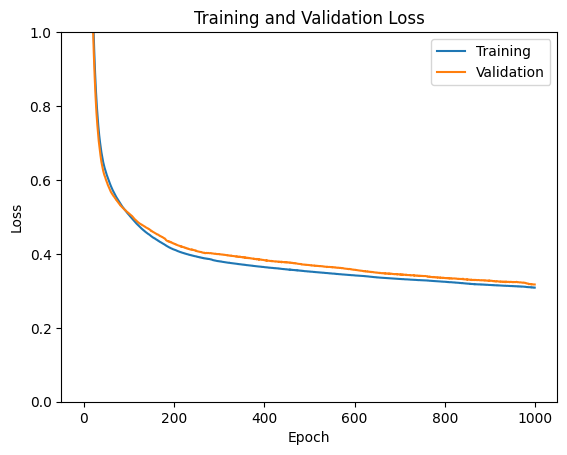

In [ ]:
# plot how the accuracy on the training and validation datasets evolved during training
plt.figure()
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
# Use the model to make predictions
y_pred = model.predict(X_test)
residuals = y_test - y_pred
y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)
residuals_original = y_test_original - y_pred_original
scorer = tf.keras.metrics.RootMeanSquaredError()
scorer.update_state(y_test, y_pred)
print("RMSE (normalized):", scorer.result().numpy())
scorer.update_state(y_test_original, y_pred_original)
print("RMSE (original units):", scorer.result().numpy())

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE (normalized): 0.42846808
RMSE (original units): 10.705487


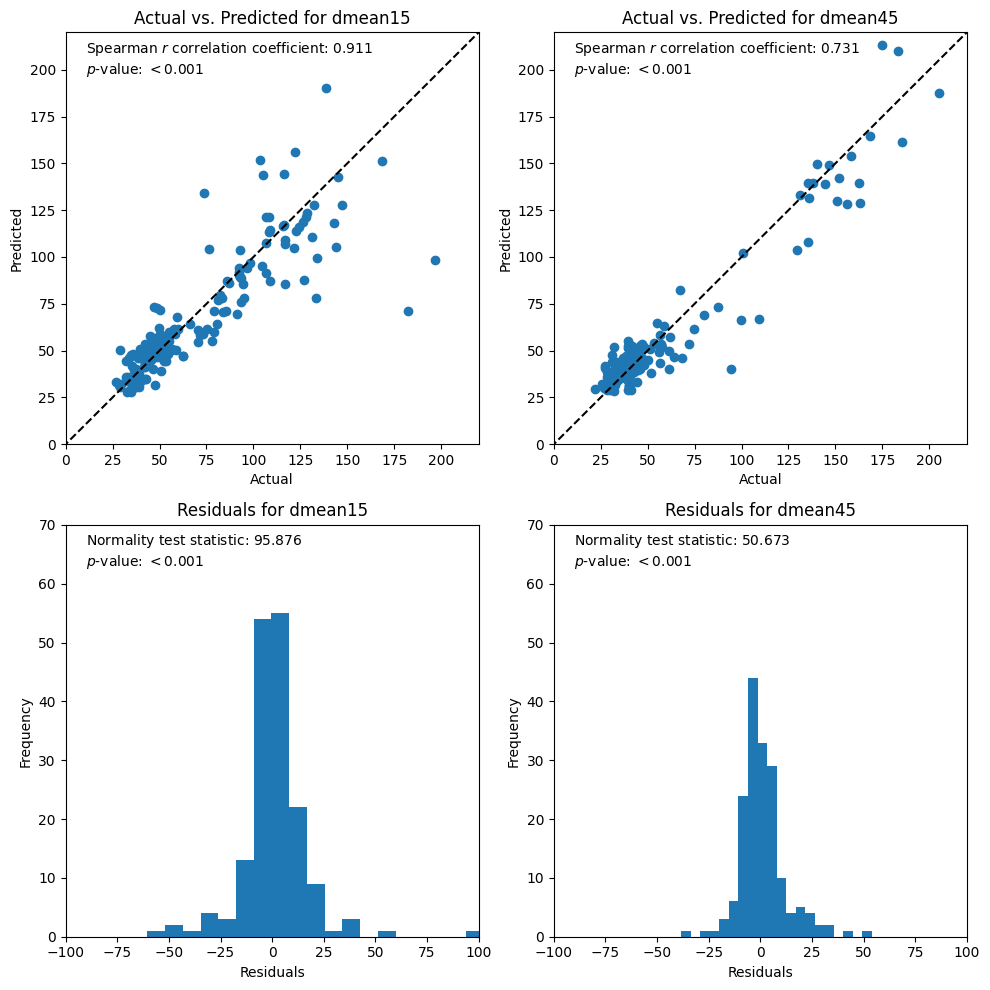

In [ ]:
# Compare predictions with the actual values
fig, axs = plt.subplots(2,2, figsize=(10,10))
for nf in range(y.shape[1]):
  scatter_ax, hist_ax = axs[:, nf]
  # Scatter plot
  scatter_ax.scatter(y_test_original[:,nf], y_pred_original[:,nf])
  scatter_ax.set_xlim([0,220])
  scatter_ax.set_ylim([0,220])
  scatter_ax.plot([-10,220],[-10,220], 'k--')
  scatter_ax.set_xlabel('Actual')
  scatter_ax.set_ylabel('Predicted')
  scatter_ax.set_title(f'Actual vs. Predicted for {target_labels[nf]}')
  sr = stats.spearmanr(y_test_original[:,nf], y_pred_original[:,nf])
  sr_text = f'Spearman $r$ correlation coefficient: ${sr.statistic.round(3)}$'
  p_text = f'$p$-value: ${sr.pvalue:.3f}$'  if sr.pvalue > 0.001 else f'$p$-value: $<0.001$'
  scatter_ax.annotate(sr_text, xy=(0.05, 0.95), xycoords='axes fraction')
  scatter_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
  #histogram
  hist_ax.hist(residuals_original[:,nf], bins=20)
  hist_ax.set_xlim([-100,100])
  hist_ax.set_ylim([0,70])
  hist_ax.set_xlabel('Residuals')
  hist_ax.set_ylabel('Frequency')
  hist_ax.set_title(f'Residuals for {target_labels[nf]}')
  nt = stats.normaltest(residuals_original[:,nf])
  nt_text = f'Normality test statistic: ${nt.statistic.round(3)}$'
  p_text = f'$p$-value: ${nt.pvalue:.3f}$'  if nt.pvalue > 0.001 else f'$p$-value: $<0.001$'
  hist_ax.annotate(nt_text, xy=(0.05, 0.95), xycoords='axes fraction')
  hist_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
fig.tight_layout();

#Compare this to a linear regression / model:

In [ ]:
# Initialize a sequential model
model = Sequential()

# readout layer
model.add(Dense(units=y.shape[1], input_dim=X.shape[1], activation='linear'))

# Compile the model with mean squared error loss and an optimizer
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 2)                   │              52 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52 (208.00 B)

 Trainable params: 52 (208.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=val_split, verbose=1)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.9126 - val_loss: 2.1037
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6201 - val_loss: 1.9519
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5761 - val_loss: 1.8347
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2668 - val_loss: 1.7375
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5316 - val_loss: 1.6501
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2841 - val_loss: 1.5794
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2308 - val_loss: 1.5179
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1345 - val_loss: 1.4603
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0865 - val_loss: 1.4082
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0784 - val_loss: 1.3575
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0375 - val_loss: 1.3141
Epoch 12/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
# plot how the accuracy on the training and validation datasets evolved during training
plt.figure()
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
# Use the model to make predictions
y_pred = model.predict(X_test)
residuals = y_test - y_pred
y_test_original, y_pred_original = Y_scaler.inverse_transform(y_test), Y_scaler.inverse_transform(y_pred)
residuals_original = y_test_original - y_pred_original
scorer = tf.keras.metrics.RootMeanSquaredError()
scorer.update_state(y_test, y_pred)
print("RMSE (normalized):", scorer.result().numpy())
scorer.update_state(y_test_original, y_pred_original)
print("RMSE (original units):", scorer.result().numpy())

In [ ]:
# Compare predictions with the actual values
fig, axs = plt.subplots(2,2, figsize=(10,10))
for nf in range(y.shape[1]):
  scatter_ax, hist_ax = axs[:, nf]
  # Scatter plot
  scatter_ax.scatter(y_test_original[:,nf], y_pred_original[:,nf])
  scatter_ax.set_xlim([0,220])
  scatter_ax.set_ylim([0,220])
  scatter_ax.plot([-10,220],[-10,220], 'k--')
  scatter_ax.set_xlabel('Actual')
  scatter_ax.set_ylabel('Predicted')
  scatter_ax.set_title(f'Actual vs. Predicted for {target_labels[nf]}')
  sr = stats.spearmanr(y_test_original[:,nf], y_pred_original[:,nf])
  sr_text = f'Spearman $r$ correlation coefficient: ${sr.statistic.round(3)}$'
  p_text = f'$p$-value: ${sr.pvalue:.3f}$'  if sr.pvalue > 0.001 else f'$p$-value: $<0.001$'
  scatter_ax.annotate(sr_text, xy=(0.05, 0.95), xycoords='axes fraction')
  scatter_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
  #histogram
  hist_ax.hist(residuals_original[:,nf], bins=20)
  hist_ax.set_xlim([-100,100])
  hist_ax.set_ylim([0,70])
  hist_ax.set_xlabel('Residuals')
  hist_ax.set_ylabel('Frequency')
  hist_ax.set_title(f'Residuals for {target_labels[nf]}')
  nt = stats.normaltest(residuals_original[:,nf])
  nt_text = f'Normality test statistic: ${nt.statistic.round(3)}$'
  p_text = f'$p$-value: ${nt.pvalue:.3f}$'  if nt.pvalue > 0.001 else f'$p$-value: $<0.001$'
  hist_ax.annotate(nt_text, xy=(0.05, 0.95), xycoords='axes fraction')
  hist_ax.annotate(p_text, xy=(0.05, 0.90), xycoords='axes fraction')
fig.tight_layout();